In [4]:
import yfinance as yf
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.stats as sps
import pmdarima as arima
from arch import arch_model

In [24]:
spy = yf.download("SPY", start="2010-01-01", end="2025-05-17")
time.sleep(5)
nvda = yf.download("NVDA", start="2010-01-01", end="2025-05-17")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [25]:
x = yf.download("X",start="2010-01-01", end="2025-05-17")
x.to_csv("x.csv")

[*********************100%***********************]  1 of 1 completed


In [26]:
nvda.to_csv('nvda.csv')
spy.to_csv('spy.csv')

In [27]:
print(nvda.shape)
print(nvda.columns)
print(spy.columns)

(3867, 5)
MultiIndex([( 'Close', 'NVDA'),
            (  'High', 'NVDA'),
            (   'Low', 'NVDA'),
            (  'Open', 'NVDA'),
            ('Volume', 'NVDA')],
           names=['Price', 'Ticker'])
MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])


In [28]:
print(spy.iloc[0].shape)
print(2*3774*2)

(5,)
15096


In [5]:
def load_data(file):
    xdat = pd.read_csv(file,skiprows=2)

    xdat.columns = ['Date','Close','High','Low','Open','Volume']
    xdat['Date'] = pd.to_datetime(xdat['Date'])
    
    return xdat

In [6]:
def plot_data(xdat:pd.DataFrame):
    plt.plot(xdat['Date'],xdat['Close'])
    plt.title("Prices")
    plt.show()

    xdat['logReturns'] = np.log1p(xdat.Close).diff()
    xdat['Squared_logReturns'] = (xdat.logReturns)**2

    plt.plot(xdat['Date'],xdat['logReturns'])
    plt.title("log-Returns")
    plt.show()

    plt.plot(xdat['Date'],xdat['Squared_logReturns'])
    plt.title("Squared log-Returns")
    plt.show()

# Asset 1

           Date      Close       High        Low       Open     Volume
3517 2023-12-22  48.811672  49.364462  48.448806  49.176533  252507000
3518 2023-12-26  49.260498  49.581377  48.941618  48.949614  244200000
3519 2023-12-27  49.398445  49.661347  49.066569  49.492412  233648000
3520 2023-12-28  49.503410  49.865274  49.393451  49.624367  246587000
3521 2023-12-29  49.503410  49.978234  48.732700  49.794301  389293000


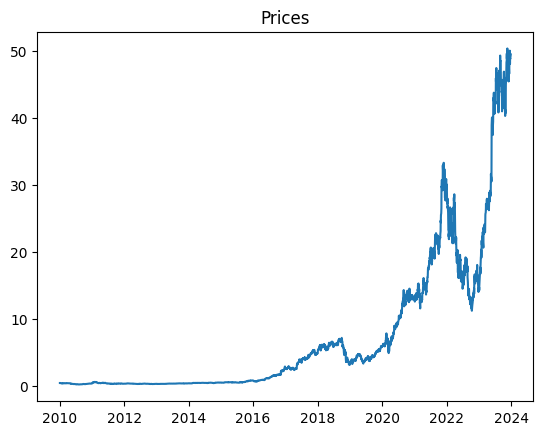

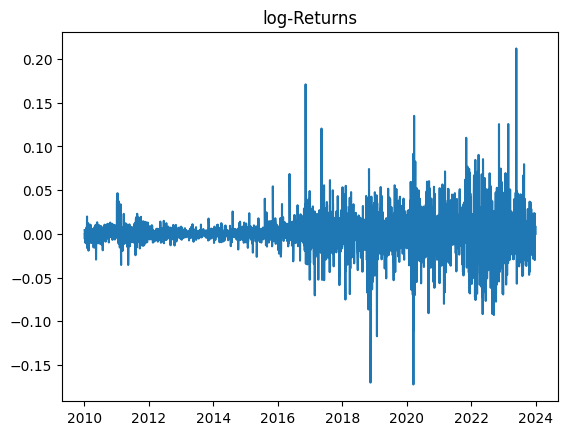

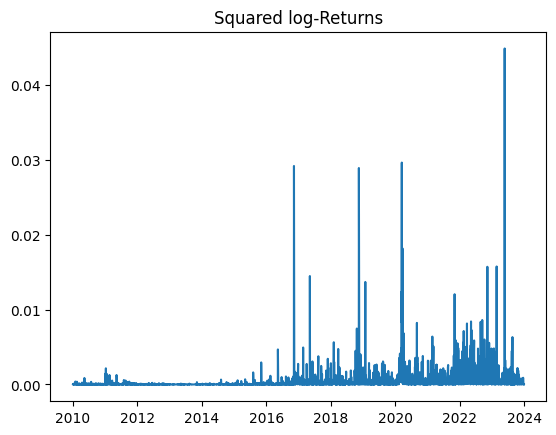

In [7]:
ticket = "nvda"
nvda = load_data(ticket + ".csv")
nvda = nvda[nvda['Date'] <= '2023-12-31']
print(nvda.tail())
plot_data(nvda)

# Asset 2

        Date      Close       High        Low       Open     Volume
0 2010-01-04  85.768448  85.813854  84.391067  85.041918  118944600
1 2010-01-05  85.995491  86.033333  85.405186  85.715478  111579900
2 2010-01-06  86.056046  86.267949  85.844142  85.912251  116074400
3 2010-01-07  86.419304  86.525256  85.654932  85.897108  131091100
4 2010-01-08  86.706863  86.744706  86.018176  86.192237  126402800


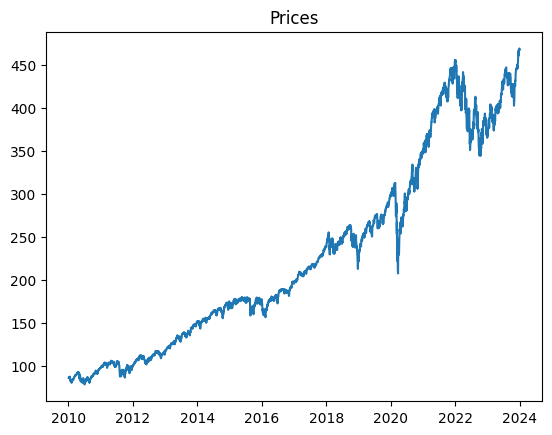

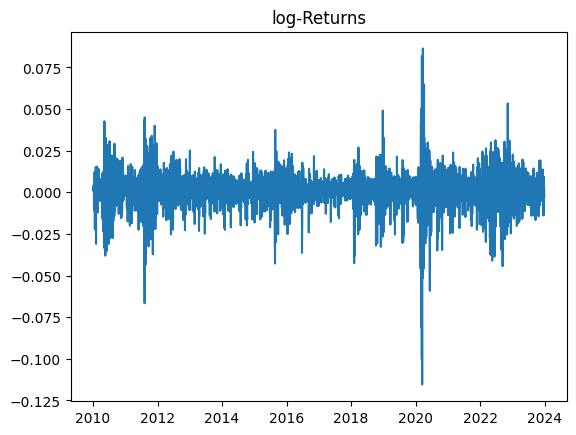

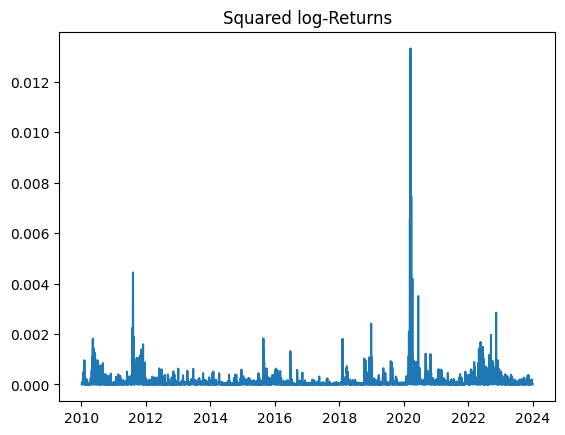

In [8]:
ticket = "spy"
spy = load_data(ticket+".csv")
spy = spy[spy['Date'] <= '2023-12-31']
print(spy.head())
plot_data(spy)

# Risk Comparison

In [9]:
def get_dataset(data, train: bool):
    if train:
        return data[data['Price'] <= '2023-12-31']
    else:
        return data[data['Price'] > '2023-12-31']

def compute_returns(data: pd.DataFrame):
    prices = data["Close"]
    returns = (prices / prices.shift(1)) - 1
    returns = returns.fillna(0)
    return returns

In [10]:
x = pd.read_csv("x.csv",skiprows=[1,2])
data = get_dataset(x,train=True)
x_r = compute_returns(data)

In [11]:
spy = pd.read_csv("spy.csv",skiprows=[1,2])
data = get_dataset(spy,train=True)
spy_r = compute_returns(data)

In [12]:
nvda = pd.read_csv("nvda.csv",skiprows=[1,2])
data = get_dataset(nvda,train=True)
nvda_r = compute_returns(data)

In [13]:
mean_spy=spy_r.expanding().mean()
mean_x=x_r.expanding().mean()
mean_nvda=nvda_r.expanding().mean()

var_spy=spy_r.expanding().var()
var_x=x_r.expanding().var()
var_nvda=nvda_r.expanding().var()

print("NaN in mean_spy:", mean_spy.isna().sum())
print("NaN in mean_x:", mean_x.isna().sum())
print("NaN in mean_nvda:", mean_nvda.isna().sum())

print("Length of mean_spy:", len(mean_spy))
print("Length of mean_x:", len(mean_x))
print("Length of mean_nvda:", len(mean_nvda))

NaN in mean_spy: 0
NaN in mean_x: 0
NaN in mean_nvda: 0
Length of mean_spy: 3522
Length of mean_x: 3522
Length of mean_nvda: 3522


In [14]:
b = mean_spy>mean_x
print(np.sum(b)/len(b))

b2 = var_spy>var_x
print(np.sum(b2)/len(b2))

0.9642248722316865
0.00028392958546280523


In [15]:
b = mean_spy>mean_nvda 
print(np.sum(b)/len(b))

b2 = var_spy>var_nvda
print(np.sum(b2)/len(b2))

0.3940942646223736
0.0


In [16]:
b = mean_nvda>mean_x 
print(np.sum(b)/len(b))

b2 = var_nvda>var_x 
print(np.sum(b2)/len(b2))

0.9327086882453152
0.049403747870528106


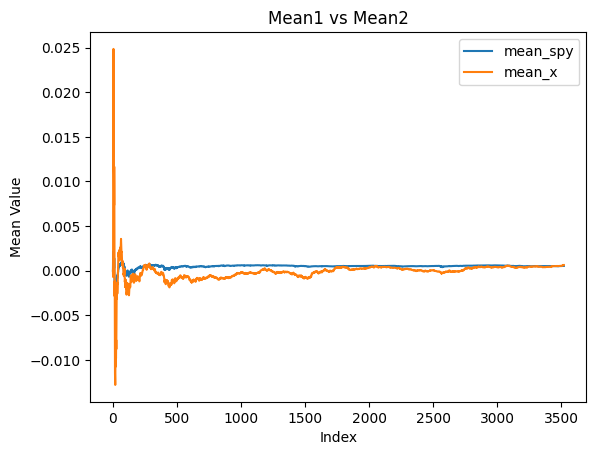

In [17]:
plt.plot(mean_spy, label='mean_spy')
plt.plot(mean_x, label='mean_x')
plt.title('Mean1 vs Mean2')
plt.xlabel('Index')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

# Minimum Variance Portfolio

In [18]:
def get_mvp(var1,var2,cov):
    std1 = torch.sqrt(var1)
    std2 = torch.sqrt(var2)
    corr = cov/(std1*std2)
    nom = var2 - (corr*std1*std2)
    den = var1 + var2 - (2*corr*std1*std2)
    return nom/den

def get_capital_values(capital,w):
    return w * capital, (1-w)*capital

def get_return_values(returns,w):
    return w * returns + (1-w)*returns

In [345]:
def get_VaR(alpha, mean, std):
    VaR = mean + (std*sps.norm.ppf(q=1-alpha,loc=0,scale=1))
    return VaR

def get_ES(alpha, mean, std):
    levels5 = np.linspace(0.001,0.05,40)
    q5 = sps.norm.ppf(levels5, 0, 1)
    mean5 = q5.mean()
    return mean + std*(mean5)

# ARIMA

In [329]:
from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#spy_r_scaled = scaler.fit_transform(spy_r.values.reshape(-1, 1))
spy_r_scaled = np.log1p(spy_r)

arima_model = arima.AutoARIMA(d=0,information_criterion="bic")
arima_model.fit(y=spy_r_scaled)

c:\Users\panal\AppData\Local\Programs\Python\Python312\enviroments\ai-finance\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\panal\AppData\Local\Programs\Python\Python312\enviroments\ai-finance\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\panal\AppData\Local\Programs\Python\Python312\enviroments\ai-finance\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\panal\AppData\Local\Programs\Python\Python312\enviroments\ai-finance\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

AutoARIMA(d=0, information_criterion='bic')

In [346]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3522
Model:               SARIMAX(2, 0, 0)   Log Likelihood               10924.475
Date:                Wed, 21 May 2025   AIC                         -21842.950
Time:                        15:34:57   BIC                         -21824.450
Sample:                             0   HQIC                        -21836.350
                               - 3522                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0962      0.008    -12.653      0.000      -0.111      -0.081
ar.L2          0.0565      0.007      8.278      0.000       0.043       0.070
sigma2         0.0001   1.18e-06    100.474      0.0

In [347]:
test_data = get_dataset(spy,train=False)
y_true = compute_returns(test_data)
#y_true = scaler.transform(y_true.values.reshape(-1, 1))
y_true = np.log1p(y_true)

y_pred = arima_model.predict(len(y_true))

mae = np.mean(np.abs(y_true - y_pred))
mse = np.mean((y_true - y_pred)**2)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")

print(y_true.iloc[0], y_pred.iloc[0])
print(y_true.iloc[1], y_pred.iloc[1])
print(y_true.iloc[2], y_pred.iloc[2])

MAE: 0.007270
MSE: 0.000131
RMSE: 0.011454
0.0 0.00030010888926528814
-0.008200314302334153 -0.00019268492113273133
-0.0032262237758721507 3.5486668534468296e-05


c:\Users\panal\AppData\Local\Programs\Python\Python312\enviroments\ai-finance\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [348]:
generated,conf = arima_model.predict(n_periods=len(y_true),return_conf_int=True)
len(generated)

c:\Users\panal\AppData\Local\Programs\Python\Python312\enviroments\ai-finance\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\panal\AppData\Local\Programs\Python\Python312\enviroments\ai-finance\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


345

In [349]:
std = (conf[:, 1] - conf[:, 0]) / (2 * 1.96)
mean = generated

In [353]:
VaR = get_VaR(0.95,mean=mean,std=std)
print("Mean Var95",np.mean(VaR))
ES = get_ES(0.95,mean=mean,std=std)
print("Mean Var99",np.mean(ES))

Mean Var95 -0.018018857874240957
Mean Var99 -0.022403562938622987


In [354]:
print((np.where((y_true <= VaR), 1, 0)).mean()) #test
print((np.where((spy_r <= np.mean(VaR)), 1, 0)).mean()) #train
print((np.where((y_true <= ES), 1, 0)).mean()) #test
print((np.where((spy_r <= np.mean(ES)), 1, 0)).mean()) #train

0.03768115942028986
0.04258943781942078
0.02608695652173913
0.02668938103350369


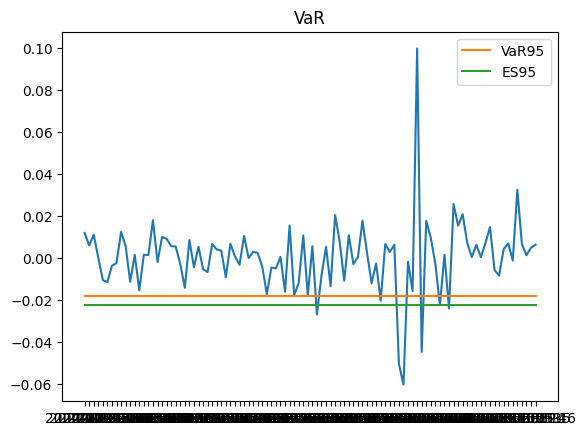

In [356]:
tail = 100
plt.plot(spy['Price'][-tail:],y_true[-tail:])
plt.plot(spy['Price'][-tail:],VaR[-tail:], label='VaR95')
plt.plot(spy['Price'][-tail:],ES[-tail:], label='ES95')
plt.title("VaR")
plt.legend()
plt.show()

# GARCH

In [367]:
distributions = ['normal', 't', 'skewt']
best_metric = np.inf
best_model = None

spy_r_normalized = (spy_r - spy_r.mean()) / spy_r.std()

for dist in distributions:
    for p in range(1, 4):
        for q in range(1, 4):
            try:
                model = arch_model(spy_r_normalized, vol='Garch', p=p, q=q, dist=dist,rescale=False)
                res = model.fit(disp='off',update_freq=0, cov_type="robust")
                if res.aic < best_metric:
                    best_metric = res.aic
                    best_model = res
                    best_config = (p, q, dist)
            except:
                continue

print("Best config:", best_config)
print("Best BIC:", best_metric)


Best config: (2, 1, 'skewt')
Best BIC: 8218.160879237119


In [368]:
def generate_autoregressive(res, generate_len):
    sim = res.model.simulate(res.params, nobs=generate_len)
    simulated_returns = sim['data'].to_numpy()
    return simulated_returns

In [369]:
true_returns = compute_returns(test_data)

In [370]:
generated_returns = generate_autoregressive(best_model, generate_len=1_000_000)
generated_returns = generated_returns * spy_r.std() + spy_r.mean()

In [371]:
print(res.params)

mu          2.597058e-02
omega       2.843854e-02
alpha[1]    1.104401e-01
alpha[2]    1.308282e-01
alpha[3]    1.518983e-15
beta[1]     6.257990e-01
beta[2]     9.555567e-16
beta[3]     1.164342e-01
eta         6.337957e+00
lambda     -1.128182e-01
Name: params, dtype: float64


In [372]:
generated_returns.shape

(1000000,)

In [378]:
VaRG = np.percentile(generated_returns,q=5)
ESG = generated_returns[generated_returns <= VaRG].mean()

In [379]:
print(VaRG)
print(ESG)

-0.01588724934271823
-0.029544596538649135


In [382]:
print((np.where((spy_r <= VaRG), 1, 0)).mean())
print((np.where((spy_r <= ESG), 1, 0)).mean())

0.056218057921635436
0.01306076093128904


In [383]:
print((np.where((true_returns <= VaRG), 1, 0)).mean())
print((np.where((true_returns <= ESG), 1, 0)).mean())

0.05507246376811594
0.011594202898550725


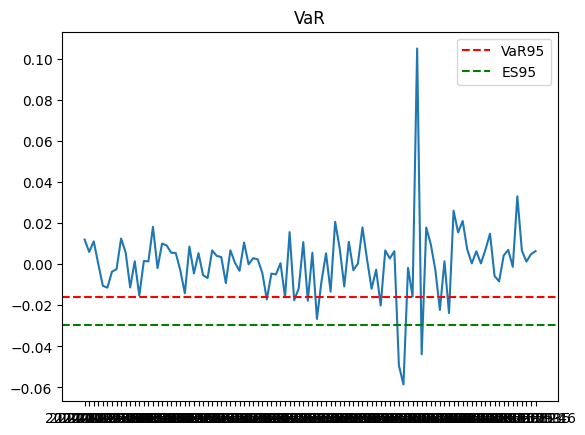

In [386]:
tail = 100
plt.plot(spy['Price'][-tail:],true_returns[-tail:])
plt.axhline(VaRG, color='red', linestyle='--', label='VaR95')
plt.axhline(ESG, color='green', linestyle='--', label='ES95')
plt.title("VaR")
plt.legend()
plt.show()

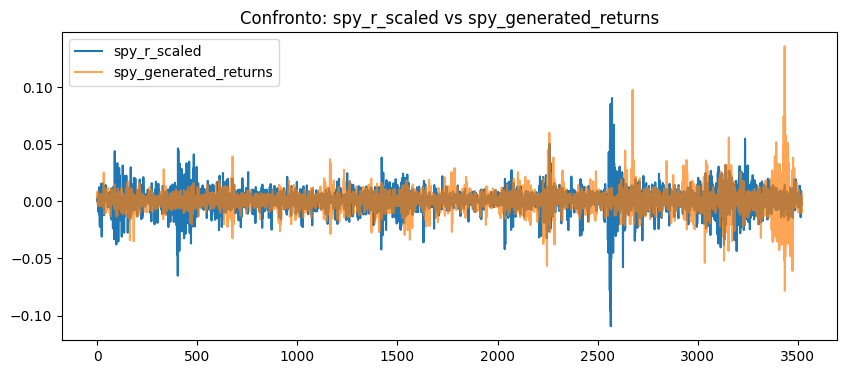

In [387]:
plt.figure(figsize=(10,4))
plt.plot(spy_r, label="spy_r_scaled")
plt.plot(generated_returns[:len(spy_r_scaled)], label="spy_generated_returns", alpha=0.7)
plt.title("Confronto: spy_r_scaled vs spy_generated_returns")
plt.legend()
plt.show()